<a id =t> </a> <br>
***

# <center> <span style="color:blue;background:yellow"> [WNS Analytics Wizard 2019 - Click Rate Prediction](https://datahack.analyticsvidhya.com/contest/wns-analytics-wizard-2019/) </span></center>

![](images/wns.png)
*** 

## Notebook Content
1. [Load Libraries](#0)
1. [Load Data](#1)
1. [Preprocessing](#a)
    1. [Process Logs and Items Data](#b)
    1. [Label Encoding](#2)
    1. [Date Columns Processing](#3)
1. [Feature Engineering](#4)
1. [LightGBM](#5)
    1. [Hyperparameters Optimization](#6)
    1. [Model Training and Prediction](#7)
    1. [Submission DataFrame](#8)

---

In [7]:
# # Read file from Gdrive
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
!sudo pip install bayesian-optimization

<a id=0> </a> <br>

## <span style="background:gray;color:red">1. </span><span style="background:yellow;color:blue">Load Libraries </span>

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings('ignore')

<a id=1> </a> <br>

## <span style="background:gray;color:red">2. </span><span style="background:yellow;color:blue">Load Data </span>

In [10]:
# Load Data
train = pd.read_csv('/content/drive/My Drive/WNS Analytics Wizard 2019/Data/train/train.csv')
test = pd.read_csv('/content/drive/My Drive/WNS Analytics Wizard 2019/Data/test/test.csv')

logs = pd.read_csv('/content/drive/My Drive/WNS Analytics Wizard 2019/Data/train/view_log.csv')  # Log details of user ids
items = pd.read_csv('/content/drive/My Drive/WNS Analytics Wizard 2019/Data/train/item_data.csv') # Item details


In [11]:
print('Shape of train Data :', train.shape, '\n Shape of test data :', test.shape)

Shape of train Data : (237609, 7) 
 Shape of test data : (90675, 6)


In [12]:
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [13]:
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1


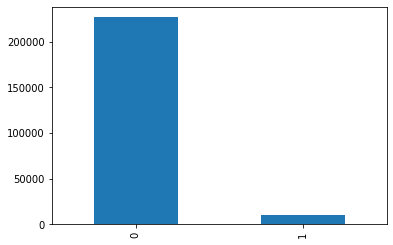

In [14]:
train['is_click'].value_counts().plot(kind='bar')

In [15]:
print('Click percentage :', train['is_click'].value_counts()[1]/train['is_click'].value_counts().sum()*100 , '%')

Click percentage : 4.571375663379754 %


In [16]:
logs.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [17]:
logs.shape

(3118622, 5)

In [18]:
items.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [19]:
items.shape

(132761, 6)

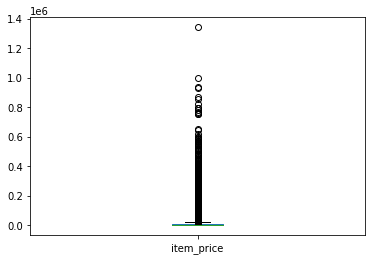

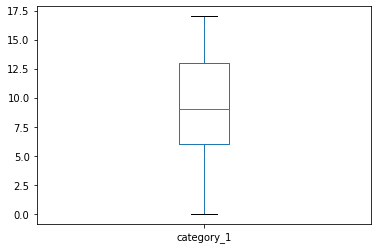

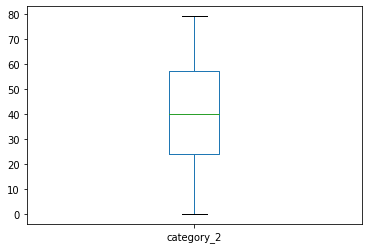

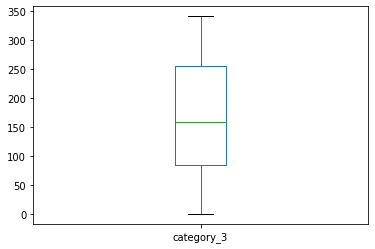

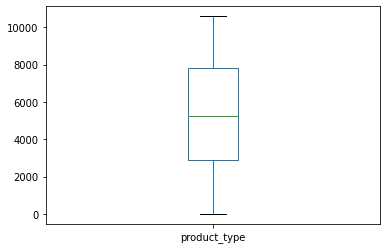

In [20]:
for col in items.columns[1:]:
    items[col].plot(kind='box')
    plt.show()

There are no outliers in items' variables but in product price.

<a id=a> </a> <br>

## <span style="background:gray;color:red">3. </span><span style="background:yellow;color:blue">Preprocessing </span>

In [21]:
target = train['is_click'] # Get labels 
train.drop('is_click', axis=1, inplace=True) # Remove labels

<a id=b> </a> <br>

### <span style="background:gray;color:red">3.1 </span><span style="background:yellow;color:blue">Process Logs and Items Data </span>
* Merge Logs and Items DataFrame on `item_id`
* Merge new train and test DataFrames with Logs and Items merge DataFrame on `user_id'
* Create a Pivot table---> Make  pivot table with  `impression_id` as index , choose columns and define opeartions on them.
* Reset index of Pivot Table
* Rename columns of Pivot Table
* Merge Train and Test DataFrame with Pivot Table on `impression_id` 

In [22]:
df1 = pd.merge(logs,items, on='item_id', how="left")

In [23]:
%%time
def process_log_item(df):
    df_new = pd.merge(df,df1, on ="user_id", how="left")
    
    df_new = pd.pivot_table(df_new, index ='impression_id', 
               values=['user_id','item_id', 'item_price','category_1','category_2','category_3', 'product_type'], 
              aggfunc={'user_id':len,'item_id': lambda x:len(set(x)),
                       'item_price':[np.median,np.sum],
                       'category_1':[np.min, np.mean, np.max],
                       'category_2':[np.min, np.mean, np.max],
                       'category_3':[np.min, np.mean, np.max],
                       'product_type':[np.min, np.max]
                      })
    df_new = df_new.reset_index()
    
    df_new.columns = ['impression_id','cat1_max', 'cat1_min', 'cat1_mean',
                    'cat2_max', 'cat2_min', 'cat2_mean',
                    'cat3_max', 'cat3_min', 'cat3_mean',
                     'item_count',
                    'price_median', 'price_sum',
                    'product_type_max', 'product_type_min',
                    'impression_count']
    df = pd.merge(df,df_new, on ="impression_id", how="left" )
    return df

train = process_log_item(train)
test = process_log_item(test)

CPU times: user 19.5 s, sys: 1.09 s, total: 20.6 s
Wall time: 20.5 s


In [24]:
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,cat1_max,cat1_min,cat1_mean,cat2_max,cat2_min,cat2_mean,cat3_max,cat3_min,cat3_mean,item_count,price_median,price_sum,product_type_max,product_type_min,impression_count
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,11.0,11.0,11.000000,35.0,35.0,35.000000,20.0,20.0,20.000000,1,2350.0,2350.0,5622.0,5622.0,1
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,13.0,4.0,7.333333,76.0,43.0,67.000000,295.0,67.0,257.500000,7,3421.0,53434.0,9337.0,577.0,12
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,13.0,8.0,10.500000,67.0,21.0,44.000000,170.0,139.0,154.500000,2,1598.5,3197.0,2874.0,2325.0,2
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,17.0,0.0,9.277778,63.0,21.0,44.333333,313.0,20.0,159.444444,12,2307.0,179341.0,9959.0,1943.0,18
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,17.0,1.0,9.978261,76.0,0.0,32.652174,332.0,11.0,168.391304,34,3596.5,396471.0,10412.0,248.0,46


In [25]:
rm_col=['impression_id']

In [26]:
train1 = train.drop(rm_col, axis=1)

test1 = test.drop(rm_col, axis=1)

In [27]:
print('Shape of train Data :', train1.shape, '\n Shape of test data :', test1.shape)

Shape of train Data : (237609, 20) 
 Shape of test data : (90675, 20)


In [28]:
train1 = train1.fillna(0)
test1 = test1.fillna(0)

In [29]:
test1.head()

,impression_time,user_id,app_code,os_version,is_4G,cat1_max,cat1_min,cat1_mean,cat2_max,cat2_min,cat2_mean,cat3_max,cat3_min,cat3_mean,item_count,price_median,price_sum,product_type_max,product_type_min,impression_count
0,2018-12-13 07:44:00,44754,127,latest,1,1.0,1.0,1.000000,42.0,42.0,42.000000,220.0,220.0,220.000000,1,23424.0,23424.0,1617.0,1617.0,1
1,2018-12-13 07:45:00,29656,44,latest,0,17.0,0.0,9.638889,78.0,3.0,38.430556,336.0,15.0,138.000000,46,3840.0,774171.0,10059.0,507.0,72
2,2018-12-13 07:46:00,25234,296,latest,1,17.0,7.0,12.555556,46.0,0.0,20.444444,328.0,4.0,201.222222,7,2116.0,44771.0,5552.0,60.0,9
3,2018-12-13 07:47:00,22988,207,latest,1,17.0,0.0,7.162162,76.0,0.0,33.108108,338.0,84.0,219.432432,17,5248.0,555344.0,9776.0,344.0,37
4,2018-12-13 07:48:00,35431,242,latest,1,17.0,0.0,8.178571,78.0,3.0,36.678571,308.0,18.0,143.285714,26,3105.0,245792.0,10412.0,1349.0,28


<a id=2> </a> <br>

### <span style="background:gray;color:red">3.2 </span><span style="background:yellow;color:blue">LabelEncoding </span>

* Do label encoding for `os_version` column

In [30]:
encode_cols = ['os_version'] #, 'device_type']
def labelencpode(df):
    enc = LabelEncoder()
    for col in encode_cols:
        enc.fit(df[col])
        df[col] = enc.transform(df[col])
    return df
train1 = labelencpode(train1)
test1 = labelencpode(test1)

In [31]:
train1.head()

,impression_time,user_id,app_code,os_version,is_4G,cat1_max,cat1_min,cat1_mean,cat2_max,cat2_min,cat2_mean,cat3_max,cat3_min,cat3_mean,item_count,price_median,price_sum,product_type_max,product_type_min,impression_count
0,2018-11-15 00:00:00,87862,422,2,0,11.0,11.0,11.000000,35.0,35.0,35.000000,20.0,20.0,20.000000,1,2350.0,2350.0,5622.0,5622.0,1
1,2018-11-15 00:01:00,63410,467,1,1,13.0,4.0,7.333333,76.0,43.0,67.000000,295.0,67.0,257.500000,7,3421.0,53434.0,9337.0,577.0,12
2,2018-11-15 00:02:00,71748,259,0,1,13.0,8.0,10.500000,67.0,21.0,44.000000,170.0,139.0,154.500000,2,1598.5,3197.0,2874.0,2325.0,2
3,2018-11-15 00:02:00,69209,244,1,1,17.0,0.0,9.277778,63.0,21.0,44.333333,313.0,20.0,159.444444,12,2307.0,179341.0,9959.0,1943.0,18
4,2018-11-15 00:02:00,62873,473,1,0,17.0,1.0,9.978261,76.0,0.0,32.652174,332.0,11.0,168.391304,34,3596.5,396471.0,10412.0,248.0,46


<a id=3> </a> <br>

### <span style="background:gray;color:red">3.3 </span><span style="background:yellow;color:blue">Date Columns Processing </span>

* Convert `impression_time` column to datetime format
* Get month, day of week, day of month and hour 

In [32]:
def date_col(df):
  df['impression_time'] = pd.to_datetime(df['impression_time'])
  df['dow'] = df['impression_time'].apply(lambda x: x.weekday())
  df["day"]  = df['impression_time'].apply(lambda x: x.day)
  df['hour'] = df['impression_time'].apply(lambda x: x.hour)
  df.drop('impression_time', axis=1, inplace=True)
  return df

train1 = date_col(train1)
test1 = date_col(test1)

<a id=4> </a> <br>

## <span style="background:gray;color:red">4. </span><span style="background:yellow;color:blue">Feature Engineering </span>

#### `I found high correlation between categories, item count, product type, and item price. To reduce correlation among them, I took ratios. It did not reduce correlation between target and independent variables.`  

In [33]:
rm_cols = ['cat1_max', 'cat1_min', 'cat1_mean','cat2_max', 'cat2_min', 'cat2_mean',
                    'cat3_max', 'cat3_min', 'cat3_mean','price_median', 'price_sum',
                    'product_type_max', 'product_type_min', 'item_count', 'impression_count']
def feat_eng(df):
    df['cat1'] = df['cat1_max']/(df['cat1_min'] + 1)
    df['cat12'] = df['cat2_max']/(df['cat2_min'] + 1)
    df['cat3'] = df['cat3_max']/ (df['cat3_min'] + 1)
    df['product_type'] = df['product_type_max'] /(df['product_type_min'] + 1)
    df['price_ratio'] = df['price_sum'] / df['price_median']
    df['f1'] = (df['cat1_mean'] + df['cat2_mean'] + df['cat3_mean'])/(df['item_count'] + df['impression_count'] )
    df['f2'] = df['item_count']/df['impression_count']
    df.drop(rm_cols, axis=1, inplace=True)
    return df
train1 = feat_eng(train1)
test1 = feat_eng(test1)

In [34]:
train1.head()

,user_id,app_code,os_version,is_4G,dow,day,hour,cat1,cat12,cat3,product_type,price_ratio,f1,f2
0,87862,422,2,0,3,15,0,0.916667,0.972222,0.952381,0.999822,1.000000,33.000000,1.000000
1,63410,467,1,1,3,15,0,2.600000,1.727273,4.338235,16.153979,15.619410,17.464912,0.583333
2,71748,259,0,1,3,15,0,1.444444,3.045455,1.214286,1.235598,2.000000,52.250000,1.000000
3,69209,244,1,1,3,15,0,17.000000,2.863636,14.904762,5.122942,77.737755,7.101852,0.666667
4,62873,473,1,0,3,15,0,8.500000,76.000000,27.666667,41.815261,110.238009,2.637772,0.739130


In [35]:
print('Shape of train Data :', train1.shape, '\n Shape of test data :', test1.shape)

Shape of train Data : (237609, 14) 
 Shape of test data : (90675, 14)


In [36]:
train1.head()

,user_id,app_code,os_version,is_4G,dow,day,hour,cat1,cat12,cat3,product_type,price_ratio,f1,f2
0,87862,422,2,0,3,15,0,0.916667,0.972222,0.952381,0.999822,1.000000,33.000000,1.000000
1,63410,467,1,1,3,15,0,2.600000,1.727273,4.338235,16.153979,15.619410,17.464912,0.583333
2,71748,259,0,1,3,15,0,1.444444,3.045455,1.214286,1.235598,2.000000,52.250000,1.000000
3,69209,244,1,1,3,15,0,17.000000,2.863636,14.904762,5.122942,77.737755,7.101852,0.666667
4,62873,473,1,0,3,15,0,8.500000,76.000000,27.666667,41.815261,110.238009,2.637772,0.739130


In [37]:
train1['is_click'] = target

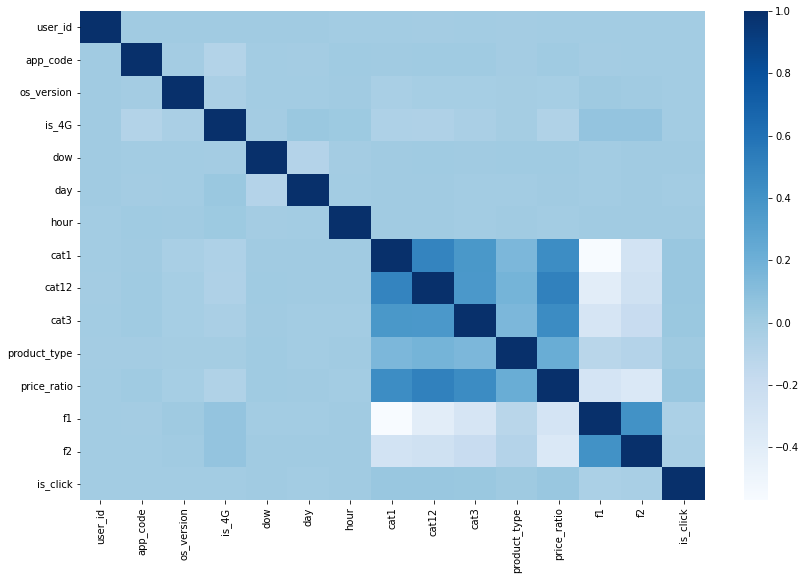

In [38]:
# Plot Correlation 
plt.subplots(figsize=(14,9))
data = train1.corr()
sns.heatmap(data, cmap ='Blues')

In [39]:
data

,user_id,app_code,os_version,is_4G,dow,day,hour,cat1,cat12,cat3,product_type,price_ratio,f1,f2,is_click
user_id,1.000000,0.000247,0.000619,0.000256,0.000825,0.001182,-0.006041,-0.002955,-0.011365,-0.003811,-0.009125,-0.003513,-0.001710,-0.002427,-0.001035
app_code,0.000247,1.000000,-0.008514,-0.081480,-0.005307,-0.008427,0.005997,0.003847,0.008389,0.007791,-0.007528,0.011439,-0.009960,-0.005235,-0.005449
os_version,0.000619,-0.008514,1.000000,-0.042513,-0.005353,-0.000696,0.001977,-0.031589,-0.021853,-0.021585,-0.016613,-0.024344,0.013109,0.000392,-0.004383
is_4G,0.000256,-0.081480,-0.042513,1.000000,-0.008040,0.031951,0.021178,-0.058799,-0.067452,-0.041895,-0.012725,-0.068685,0.054971,0.059102,-0.003464
dow,0.000825,-0.005307,-0.005353,-0.008040,1.000000,-0.090244,-0.008548,0.005072,0.008550,0.004596,0.005961,0.007911,-0.002677,0.001740,0.005079
day,0.001182,-0.008427,-0.000696,0.031951,-0.090244,1.000000,-0.000754,0.004307,-0.000254,-0.005244,-0.004282,-0.000159,-0.003164,0.003610,-0.005490
hour,-0.006041,0.005997,0.001977,0.021178,-0.008548,-0.000754,1.000000,0.002051,0.004222,-0.003659,0.001984,-0.004091,0.000783,0.000943,0.004081
cat1,-0.002955,0.003847,-0.031589,-0.058799,0.005072,0.004307,0.002051,1.000000,0.494989,0.369171,0.151979,0.438605,-0.571177,-0.271754,0.041209
cat12,-0.011365,0.008389,-0.021853,-0.067452,0.008550,-0.000254,0.004222,0.494989,1.000000,0.365118,0.171969,0.511105,-0.401906,-0.247889,0.038332
cat3,-0.003811,0.007791,-0.021585,-0.041895,0.004596,-0.005244,-0.003659,0.369171,0.365118,1.000000,0.152939,0.446636,-0.304923,-0.196411,0.031438


<span style='color:blue;background:yellow;font-size:20px'> `High correlation between independent variables doesn't affect boosting aglorithms as they take one variable at a time for split.Therefore, it is upto you, if you drop highly correlated variable or not.`  </span>

In [40]:
train1.drop('is_click', axis=1, inplace=True)

In [41]:
cat_cols = ['user_id','app_code', 'os_version', 'is_4G', 'dow', 'hour', 'day'] 

In [42]:
cat_feat =cat_cols

<a id=5> </a> <br>

## <span style="background:gray;color:red">5. </span><span style="background:yellow;color:blue">LightGBM </span>

<a id=6> </a> <br>

### <span style="background:gray;color:red">5.1 </span><span style="background:yellow;color:blue">Hyperparameters Optimization</span>

#### [Hyperparameters Optimization Tutorial](https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9) 


In [43]:
# Objective Function
train_data = lgb.Dataset(data=train1, label=target, free_raw_data=False)
evals_result = {}
def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, 
             lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'application':'binary','num_iterations': 1500,
                  'learning_rate':0.05, 'early_stopping_round':150,
                  'metric':'auc'} # ,'boost_from_average':False}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=5, seed=11,
                           stratified=True,categorical_feature=cat_feat,
                            verbose_eval =None)
        return max(cv_result['auc-mean'])

In [44]:
pbs = {'num_leaves': (200, 300),
        'feature_fraction': (0.1, 0.9),
        'bagging_fraction': (0.8, 1),
        'max_depth': (11, 29),
        'lambda_l1': (0, 2),
        'lambda_l2': (0, 3),
        'min_split_gain': (0.001, 0.1),
        'min_child_weight': (1, 10)
      }

In [46]:
optimizer = BayesianOptimization(lgb_eval, pbs, random_state=109)
optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7359   |  0.9223   |  0.4931   |  1.399    |  0.5837   |  24.95    |  7.371    |  0.03714  |  297.2    |
|  2        |  0.7356   |  0.8186   |  0.431    |  0.1221   |  0.8978   |  28.93    |  9.292    |  0.0458   |  291.9    |
|  3        |  0.7354   |  0.8583   |  0.5483   |  0.9183   |  0.05462  |  28.08    |  3.797    |  0.08432  |  202.2    |
|  4        |  0.7342   |  0.9162   |  0.5833   |  1.696    |  0.9446   |  27.99    |  7.668    |  0.09032  |  286.7    |
|  5        |  0.7329   |  0.9802   |  0.6788   |  1.054    |  2.295    |  14.98    |  7.737    |  0.07712  |  237.9    |
|  6        |  0.7375   |  0.8344   |  0.3804   |  1.711    |  0.4345   |  11.18    |  2.004    |  0.0377   |  299.7    |
|  7        |  0.7338   

In [47]:
optimizer.max

{'params': {'bagging_fraction': 0.9557812456260139,
  'feature_fraction': 0.28791245118689857,
  'lambda_l1': 1.530861596955889,
  'lambda_l2': 2.82660899184869,
  'max_depth': 27.659148702269842,
  'min_child_weight': 2.1968607447039954,
  'min_split_gain': 0.07055438822519233,
  'num_leaves': 200.25171884902966},
 'target': 0.7383154171006595}

In [48]:
p =optimizer.max['params']

In [49]:
param = {'num_leaves': int(round(p['num_leaves'])),
         'feature_fraction': p['feature_fraction'],
         'bagging_fraction': p['bagging_fraction'],
         'max_depth': int(round(p['max_depth'])),
         'lambda_l1': p['lambda_l1'],
         'lambda_l2':p['lambda_l2'],
         'min_split_gain': p['min_split_gain'],
         'min_child_weight': p['min_child_weight'],
         'learing_rate':0.01,
         'objective': 'binary',
         'boosting_type': 'gbdt',
         'verbose': 1,
         'metric': {'auc'},
         'is_unbalance': True,}
         # 'boost_from_average': False}

In [50]:
param

{'bagging_fraction': 0.9557812456260139,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.28791245118689857,
 'is_unbalance': True,
 'lambda_l1': 1.530861596955889,
 'lambda_l2': 2.82660899184869,
 'learing_rate': 0.01,
 'max_depth': 28,
 'metric': {'auc'},
 'min_child_weight': 2.1968607447039954,
 'min_split_gain': 0.07055438822519233,
 'num_leaves': 200,
 'objective': 'binary',
 'verbose': 1}

<a id=7> </a> <br>

### <span style="background:gray;color:red">5.2 </span><span style="background:yellow;color:blue">Model Training and Prediction</span>

In [51]:
%%time
nfold = 10

skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=127)

oof = np.zeros(len(train1))
predictions = np.zeros(len(test1))

i = 1
for train_index, valid_index in skf.split(target, target.values):
    print("fold {}".format(i))
    xg_train = lgb.Dataset(train1.iloc[train_index],
                           label=target[train_index],
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(train1.iloc[valid_index],
                           label=target[valid_index],
                           free_raw_data = False
                           )   
    
    clf = lgb.train(param, xg_train, 5000, valid_sets = [xg_valid],
                    categorical_feature=cat_feat,
                    verbose_eval=100, early_stopping_rounds = 50)
    
    oof[valid_index] = clf.predict(train1.iloc[valid_index], num_iteration=clf.best_iteration) 
    
    predictions += clf.predict(test1, num_iteration=clf.best_iteration) / nfold
    i = i + 1

print("\n\nCV AUC: {:<0.4f}".format(roc_auc_score(target, (oof))))

fold 1
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.74212
Early stopping, best iteration is:
[71]	valid_0's auc: 0.743391
fold 2
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.731731
Early stopping, best iteration is:
[96]	valid_0's auc: 0.732147
fold 3
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.742973
Early stopping, best iteration is:
[72]	valid_0's auc: 0.74415
fold 4
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.740844
Early stopping, best iteration is:
[55]	valid_0's auc: 0.743532
fold 5
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.725269
Early stopping, best iteration is:
[80]	valid_0's auc: 0.727078
fold 6
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.728458
Early stopping, best iteration is:
[52]	valid_0's auc: 0.732676
fold 7
Training until va

In [52]:
predictions

array([0.18104417, 0.15524684, 0.47350745, ..., 0.17725965, 0.72074763,
       0.74717287])

<a id=8> </a> <br>

### <span style="background:gray;color:red">5.3</span><span style="background:yellow;color:blue">Submission DataFrame</span>

In [54]:
sub = pd.read_csv('/content/drive/My Drive/WNS Analytics Wizard 2019/Data/Sample/sample_submission.csv')

In [55]:
sub['is_click'] = predictions

In [56]:
sub.head()

,impression_id,is_click
0,a9e7126a585a69a32bc7414e9d0c0ada,0.181044
1,caac14a5bf2ba283db7708bb34855760,0.155247
2,13f10ba306a19ce7bec2f3cae507b698,0.473507
3,39c4b4dc0e9701b55a0a4f072008fb3f,0.268837
4,bf5a572cca75f5fc67f4b14e58b11d70,0.778624


In [57]:
sub.to_csv('/content/drive/My Drive/WNS Analytics Wizard 2019/submission_lgbm.csv', index =False)

In [60]:
sub.to_csv('submission_lgbm.csv', index =False)

from google.colab import files
files.download("submission_lgbm.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



## <center><span style="background:gray;color:red">End of the NoteBook</span></center>
***

### <center><span style="background:yellow;color:blue">[GO TO TOP](#t)</span></center> 